In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch,time
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

### Settings

In [2]:
# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 25
batch_size = 128

# Architecture
num_classes = 3

torch.manual_seed(random_seed)

# Load data

In [3]:
X = np.load("Data/X.npy")[:2000].astype(float)/255
y = np.load("Data/y.npy")[:2000]

shuffle_idx = np.random.RandomState(seed=453).permutation(len(X))
percent85 = int(len(shuffle_idx)*0.85)
percent90 = int(len(shuffle_idx)*0.90)

train_ind, valid_ind, test_ind= shuffle_idx[:percent85], shuffle_idx[percent85:percent90],shuffle_idx[percent90:]

X_train, y_train, X_valid, y_valid , X_test, y_test= X[train_ind], y[train_ind],X[valid_ind], y[valid_ind], X[test_ind], y[test_ind]

del X,y

In [4]:
# for technical reasons
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
 transforms.ToTensor(),
 transforms.Normalize(
 mean,std)])

def data_loader(X,y):
    d_ts = [transform(x) for x in X]
    d_ls = []
    for i in range(len(d_ts)):
        d_ls.append([d_ts[i],int(y[i])])
    loader = DataLoader(dataset = d_ls,
                       batch_size = batch_size,
                       shuffle = True)
    return(loader)

train_loader = data_loader(X_train,y_train)
validation_loader = data_loader(X_valid,y_valid)
test_loader = data_loader(X_test,y_test)

del X_train,y_train,X_valid,y_valid,X_test,y_test

# Pre-trained AlexNet model

### Load model

In [5]:
alexnet = models.alexnet(pretrained=True)

In [6]:
alexnet.classifier[6] = nn.Linear(4096,num_classes)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train model

In [7]:
optimizer = torch.optim.Adam(alexnet.parameters(), lr=learning_rate)

In [8]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        logits= model(features.float())
        predicted_labels = torch.max(logits,1).indices
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [9]:
start_time = time.time()
train_acc,valid_acc,tr_cost = [],[],[]

In [10]:
for epoch in range(num_epochs):
    
    if epoch==10:
        break
    
    alexnet.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        ### FORWARD AND BACK PROP
        logits = alexnet(features.float())
        cost = F.cross_entropy(logits, targets.long())
        optimizer.zero_grad()
        
        tr_cost.append(float(cost))
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    alexnet.eval()
    tr_acc = compute_accuracy(alexnet, train_loader)
    ts_acc = compute_accuracy(alexnet, validation_loader)
    train_acc.append(float(tr_acc))
    valid_acc.append(float(ts_acc))
    
    print('Training accuracy: %.2f%%' % (tr_acc))
    print('Validation accuracy: %.2f%%' % (ts_acc))
    
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/014 | Cost: 1.2648
Epoch: 001/025 | Batch 005/014 | Cost: 0.9559
Epoch: 001/025 | Batch 010/014 | Cost: 0.7518
Training accuracy: 74.35%
Validation accuracy: 79.00%
Time elapsed: 3.81 min
Epoch: 002/025 | Batch 000/014 | Cost: 0.7707
Epoch: 002/025 | Batch 005/014 | Cost: 0.8251
Epoch: 002/025 | Batch 010/014 | Cost: 0.7453
Training accuracy: 78.59%
Validation accuracy: 79.00%
Time elapsed: 7.21 min
Epoch: 003/025 | Batch 000/014 | Cost: 0.5298
Epoch: 003/025 | Batch 005/014 | Cost: 0.6834
Epoch: 003/025 | Batch 010/014 | Cost: 0.5273
Training accuracy: 84.29%
Validation accuracy: 85.00%
Time elapsed: 10.73 min
Epoch: 004/025 | Batch 000/014 | Cost: 0.5589
Epoch: 004/025 | Batch 005/014 | Cost: 0.5885
Epoch: 004/025 | Batch 010/014 | Cost: 0.5722
Training accuracy: 80.59%
Validation accuracy: 83.00%
Time elapsed: 14.23 min
Epoch: 005/025 | Batch 000/014 | Cost: 0.7045
Epoch: 005/025 | Batch 005/014 | Cost: 0.5432
Epoch: 005/025 | Batch 010/014 | Cost: 0.6237


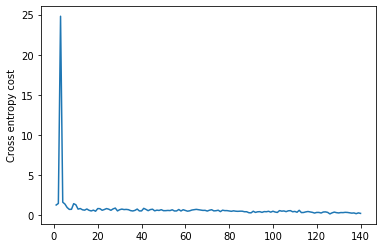

In [11]:
plt.plot(range(1,len(tr_cost)+1),np.array(tr_cost))
plt.ylabel('Cross entropy cost')
plt.show()

### Evaluation

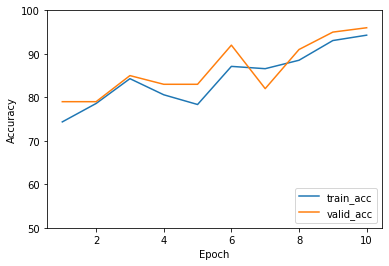

In [12]:
plt.plot(range(1, len(train_acc)+1), np.array(train_acc), label='train_acc')
plt.plot(range(1, len(valid_acc)+1), np.array(valid_acc), label='valid_acc')
plt.legend(loc='lower right')
plt.ylim([50,100])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [13]:
print('Test accuracy: %.2f%%' % compute_accuracy(alexnet, test_loader))

Test accuracy: 92.00%


### Prune and save model

In [14]:
alexnet.classifier = nn.Sequential(*list(alexnet.classifier[:6]))
torch.save(alexnet.state_dict(),'Model/alexnet.pth')